### Squeeze Excitation blocks

The Squeeze-and-Excitation (SE) block is an architectural unit designed to enhance the representational power of a network by explicitly modeling the interdependencies between the channels of its convolutional features. This mechanism was introduced in the paper "Squeeze-and-Excitation Networks" by Jie Hu et al., and is a key component in the EfficientNet architecture.

The network weights each of its channels equally when creating the output feature maps. SENets are all about changing this by adding a content aware mechanism to weight each channel adaptively. In it’s most basic form this could mean adding a single parameter to each channel and giving it a linear scalar how relevant each one is.

Key Concepts:

**Squeeze:** Get a global understanding of each channel by squeezing the feature maps to a single numeric value. This results in a vector of size n, where n is equal to the number of convolutional channels. Global information is aggregated from the input feature map via global average pooling. This results in a channel descriptor that captures the global spatial information.

**Excitation:** The channel descriptor is passed through a small neural network (a simple two-layer fully connected network with a bottleneck) to learn the importance of each channel. This network generates a set of n weights for each channel. These n values can now be used as weights on the original features maps, scaling each channel based on its importance.

**Recalibration**:** The original input feature map is reweighted (i.e., scaled) by the learned weights. This emphasizes the important channels and diminishes the less important ones.

The SE block can be described with the following steps:

1. Global Average Pooling: Reduces each channel to a single value representing the average feature response over the spatial dimensions.
2. Fully Connected Layers: Uses two fully connected (dense) layers with a ReLU activation in between to capture channel-wise dependencies.
3. Sigmoid Activation: Outputs weights between 0 and 1 for each channel.
4. Reweighting: Multiplies the original feature map by the learned weights.

By adding SE-blocks to ResNet-50 you can expect almost the same accuracy as ResNet-101 delivers. This is impressive for a model requiring only half of the computational costs. 

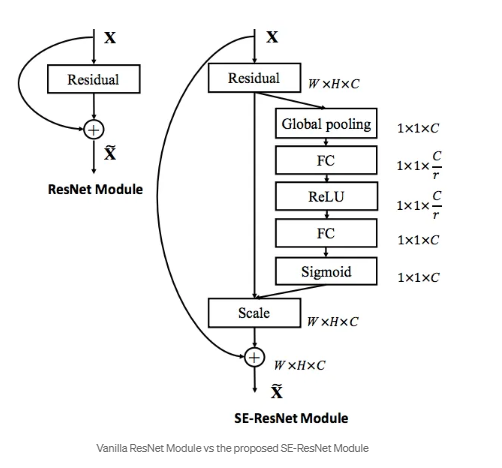

In [ ]:
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Squeeze
        batch_size, num_channels, _, _ = x.size()
        squeeze = self.global_avg_pool(x)  # Shape: (batch_size, num_channels, 1, 1)

        # Excitation
        excitation = self.fc1(squeeze)  # Shape: (batch_size, num_channels // reduction_ratio, 1, 1)
        excitation = self.relu(excitation)
        excitation = self.fc2(excitation)  # Shape: (batch_size, num_channels, 1, 1)
        excitation = self.sigmoid(excitation)

        # Reweighting
        x = x * excitation  # Shape: (batch_size, num_channels, H, W)
        return x

# Example usage
if __name__ == "__main__":
    input_tensor = torch.randn(1, 64, 32, 32)  # Example input tensor
    se_block = SEBlock(in_channels=64)
    output_tensor = se_block(input_tensor)
    print(output_tensor.shape)  # Should output torch.Size([1, 64, 32, 32])


### MBConv and SE block integration in EfficientNet

In the EfficientNet architecture, SE blocks are integrated into the mobile inverted bottleneck blocks (MBConv). 

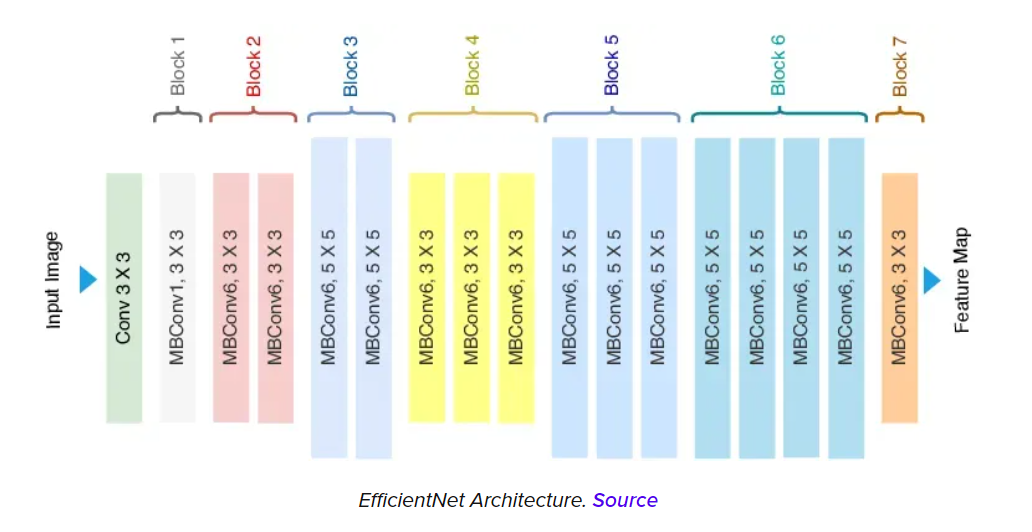

In [ ]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, reduction_ratio=16):
        super(MBConv, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_residual = (stride == 1 and in_channels == out_channels)

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))

        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))

        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)
        self.se = SEBlock(out_channels, reduction_ratio)

    def forward(self, x):
        if self.use_residual:
            return x + self.se(self.conv(x))
        else:
            return self.se(self.conv(x))

# Example usage
if __name__ == "__main__":
    input_tensor = torch.randn(1, 32, 32, 32)  # Example input tensor
    mbconv = MBConv(in_channels=32, out_channels=64, expand_ratio=6, stride=2)
    output_tensor = mbconv(input_tensor)
    print(output_tensor.shape)  # Should output torch.Size([1, 64, 16, 16])
